In [1]:
import pandas as pd
import numpy as np
import os
import io


import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [2]:
import boto3
import sagemaker

In [3]:
s3_client=boto3.client('s3')
bucket_name='aws-ml-blog-sagemaker-census-segmentation'

In [6]:
obj_list=s3_client.list_objects(Bucket=bucket_name)
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
print(files)

['Census_Data_for_SageMaker.csv']


In [7]:
file_name=files[0]

print(file_name)

Census_Data_for_SageMaker.csv


In [9]:
data_object=s3_client.get_object(Bucket=bucket_name,Key=file_name)

display(data_object)a

{'ResponseMetadata': {'RequestId': '05B042D03A06FE24',
  'HostId': 'm64T9k9sa7yuwSn5/xOO1cplUETrHWQYdfUzEQkW/qQ2Jq/RLeuVEBlN5MOQ5ExCkq1AFHGADFI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'm64T9k9sa7yuwSn5/xOO1cplUETrHWQYdfUzEQkW/qQ2Jq/RLeuVEBlN5MOQ5ExCkq1AFHGADFI=',
   'x-amz-request-id': '05B042D03A06FE24',
   'date': 'Fri, 28 Feb 2020 06:05:25 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7ff32a656198>}

In [10]:
data_body=data_object["Body"].read()
print('Data type:', type(data_body))

Data type: <class 'bytes'>


In [11]:
data_stream=io.BytesIO(data_body)
counties_df=pd.read_csv(data_stream,header=0,delimiter=",")
counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [13]:
print('(orig) rows,cols:',counties_df.shape)


clean_counties_df=counties_df.dropna(axis=0)
print('(clean) rows,cols:',clean_counties_df.shape)

(orig) rows,cols: (3220, 37)
(clean) rows,cols: (3218, 37)


In [16]:
clean_counties_df.index=clean_counties_df['State']+ "-" + clean_counties_df['County']
clean_counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [17]:
drop=["CensusId","State","County"]
clean_counties_df=clean_counties_df.drop(columns=drop)
clean_counties_df.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [18]:
features_list=clean_counties_df.columns.values
print('Features:\n', features_list)

Features:
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


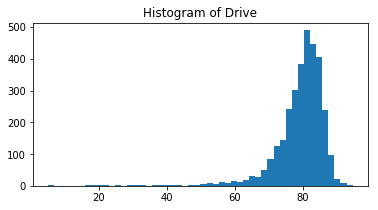

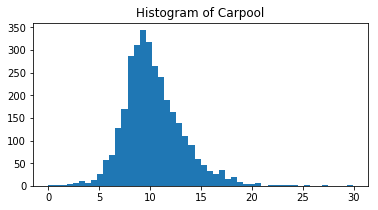

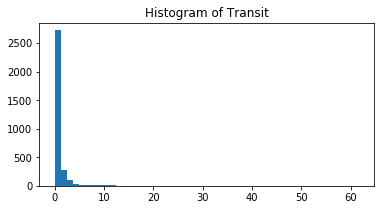

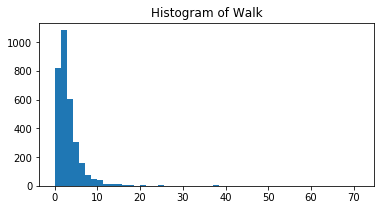

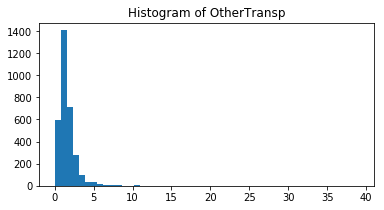

In [19]:
transport_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
n_bins = 50 # can decrease to get a wider bin (or vice versa)

for column_name in transport_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(clean_counties_df[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

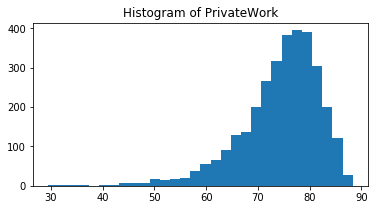

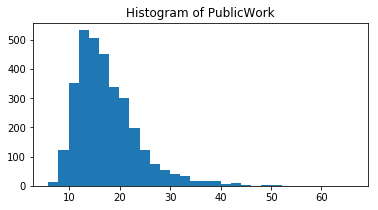

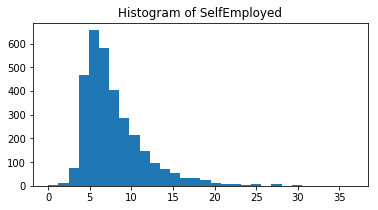

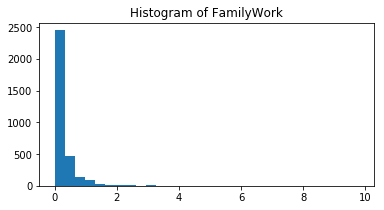

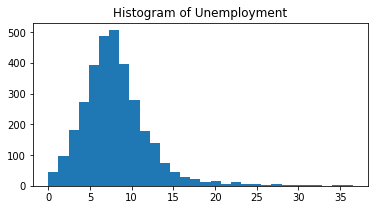

In [20]:
my_list = ['PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment']
n_bins = 30 # define n_bins

# histogram creation code is similar to above
for column_name in my_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(clean_counties_df[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
counties_scaled=pd.DataFrame(scaler.fit_transform(clean_counties_df.astype(float)))


counties_scaled.columns=clean_counties_df.columns
counties_scaled.index=clean_counties_df.index


counties_scaled.head()





,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,...,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,...,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


In [25]:
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
from sagemaker import get_execution_role

session=sagemaker.Session()

role= get_execution_role()
print(role)

arn:aws:iam::185650036310:role/service-role/AmazonSageMaker-ExecutionRole-20200228T100827


In [30]:
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-ap-south-1-185650036310



In [31]:
prefix = 'counties'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-ap-south-1-185650036310/counties/


In [32]:
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=33

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


In [34]:
train_data_np = counties_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [69]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2020-02-28 10:32:06 Starting - Starting the training job...
2020-02-28 10:32:09 Starting - Launching requested ML instances......
2020-02-28 10:33:08 Starting - Preparing the instances for training......
2020-02-28 10:34:25 Downloading - Downloading input data
2020-02-28 10:34:25 Training - Downloading the training image.Docker entrypoint called with argument(s): train
[02/28/2020 10:34:41 INFO 140527902238528] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[02/28/2020 10:34:41 INFO 140527902238528] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_components': u'33'}
[02/28/2020 10:34:41 INFO 140527902238528]


2020-02-28 10:34:50 Uploading - Uploading generated training model
2020-02-28 10:34:50 Completed - Training job completed
Training seconds: 43
Billable seconds: 43
CPU times: user 355 ms, sys: 38.6 ms, total: 394 ms
Wall time: 3min 11s


In [71]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2020-02-28-10-32-06-528'
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

aleks-weekly/models/pca-2020-02-28-10-32-06-528/output/model.tar.gz


2304

In [53]:
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [79]:
import mxnet as mx



In [81]:
features_list = counties_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


In [82]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


In [89]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

-------------!CPU times: user 236 ms, sys: 8.35 ms, total: 244 ms
Wall time: 6min 33s


In [90]:
train_pca = pca_predictor.predict(train_data_np)

In [91]:
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.0002009272575378418
      values: 0.0002455431967973709
      values: -0.0005782842636108398
      values: -0.0007815659046173096
      values: -0.00041911262087523937
      values: -0.0005133943632245064
      values: -0.0011316537857055664
      values: 0.0017268601804971695
      values: -0.005361668765544891
      values: -0.009066537022590637
      values: -0.008141040802001953
      values: -0.004735097289085388
      values: -0.00716288760304451
      values: 0.0003725700080394745
      values: -0.01208949089050293
      values: 0.02134685218334198
      values: 0.0009293854236602783
      values: 0.002417147159576416
      values: -0.0034637749195098877
      values: 0.01794189214706421
      values: -0.01639425754547119
      values: 0.06260128319263458
      values: 0.06637358665466309
      values: 0.002479255199432373
      values: 0.10011336207389832
      values: -0.1136140376329422
      values: 0

In [92]:
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    counties_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        counties_transformed=counties_transformed.append([list(components)])

    # index by county, just like counties_scaled
    counties_transformed.index=counties_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    counties_transformed = counties_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return counties_transformed.iloc[:, ::-1]
    

In [93]:
top_n = 7

# call your function and create a new dataframe
counties_transformed = create_transformed_df(train_pca, counties_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7']
counties_transformed.columns=PCA_list 

# print result
counties_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


In [94]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

In [95]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 8

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)


In [96]:
kmeans_train_data_np = counties_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [97]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data)

2020-02-28 11:38:50 Starting - Starting the training job...
2020-02-28 11:38:51 Starting - Launching requested ML instances...
2020-02-28 11:39:48 Starting - Preparing the instances for training.........
2020-02-28 11:41:17 Downloading - Downloading input data
2020-02-28 11:41:17 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[02/28/2020 11:41:34 INFO 140638194521920] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', 


2020-02-28 11:41:43 Uploading - Uploading generated training model
2020-02-28 11:41:43 Completed - Training job completed
Training seconds: 42
Billable seconds: 42
CPU times: user 393 ms, sys: 1.35 ms, total: 394 ms
Wall time: 3min 11s


In [98]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

-------------!CPU times: user 234 ms, sys: 2.37 ms, total: 236 ms
Wall time: 6min 32s


In [99]:
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

In [100]:
data_idx = 0

print('County is: ', counties_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

County is:  Alabama-Autauga

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 4.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.2867971360683441
    }
  }
}



In [101]:
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [102]:
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

4.0    820
0.0    763
1.0    411
5.0    387
2.0    377
6.0    215
7.0    149
3.0     96
Name: 0, dtype: int64


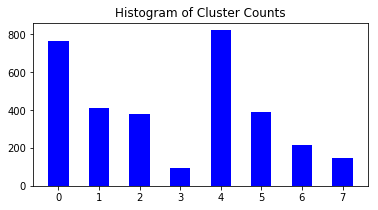

In [106]:
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

In [107]:
session.delete_endpoint(kmeans_predictor.endpoint)

In [109]:
kmeans_job_name = 'kmeans-2020-02-28-11-38-50-771'
model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file

os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')


2304

In [119]:

counties_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_counties = counties_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_counties.head(20)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,labels
Tennessee-Hardin,-0.013030,0.112563,0.243973,-0.081596,-0.167918,0.073030,0.122719,0
Kentucky-Calloway,-0.069754,0.026476,0.099582,0.005835,-0.254815,-0.056593,0.071674,0
Kentucky-Carlisle,-0.054643,0.068672,0.269404,-0.088240,-0.080919,0.089318,0.000857,0
Kentucky-Carroll,0.053264,0.224242,0.278937,-0.210973,-0.029891,-0.125506,-0.060314,0
Kentucky-Carter,-0.113807,0.213372,0.174379,-0.156952,0.039548,0.190892,-0.137219,0
Kentucky-Casey,-0.050371,0.166349,0.244804,-0.140380,-0.041132,0.154682,0.098509,0
Kentucky-Christian,0.145512,0.074783,0.072191,0.113240,-0.088046,-0.163855,-0.039923,0
Tennessee-Dickson,-0.124742,0.181827,0.049309,-0.100469,0.030517,0.166734,-0.040469,0
Kentucky-Clay,0.263388,0.151914,0.455163,-0.080330,-0.152350,0.271387,-0.052811,0
Kentucky-Clinton,-0.045153,0.094193,0.345715,-0.118339,-0.127935,-0.067662,-0.006697,0


In [120]:
cluster=counties_transformed[counties_transformed['labels']==1]
cluster.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,labels
Alaska-Denali Borough,-0.344304,-0.600848,-0.034970,0.278201,0.059686,-0.010032,-0.261428,1
Alaska-Haines Borough,-0.353209,-0.527195,-0.000119,0.215627,0.172854,-0.307113,-0.194467,1
Alaska-Kenai Peninsula Borough,-0.222552,-0.180646,-0.071631,0.049467,0.010117,-0.022058,-0.160428,1
Alaska-Petersburg Borough,-0.131466,-0.638169,0.035987,0.251507,0.173786,-0.255204,-0.258042,1
Alaska-Sitka City and Borough,-0.149774,-0.500225,-0.190784,0.274219,-0.046695,-0.176428,-0.230608,1
